In [34]:
import numpy as np
from pandas.core.frame import DataFrame
import forces
from scipy.integrate import odeint
from scipy.stats import maxwell 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<h2 style="color:orange">Function to create N randomized particles</h2>

Average mass = D*V = 2e-6 * (4 * pi* (7.5e-7)**3)/3
tao = sqrt(lambda * Average Mass / A(l,n,p)) =  sqrt(2*Pi/k * Average Mass / 7.02158e-14)
Average velocity = 4KbT / 3M

In [35]:
par = {
            'l': 40,
            'x_r': 39.107,            
            'Rr': 5.6e-5, 
            'Rp':7.5e-7,
            'R_ratio':0,
            'n_w': 1.326,
            'n_p': 1.572
            }

In [36]:
lambd = 2*np.pi*par['Rr']/par['x_r']       #lamb = 2*pi / k where k = x/Rr
M = (4/3) * np.pi * (par['Rp']**3) *1040   #where density of silica is 1040
tao = 0.00048528                           #value obtained from mathematica
kbt = 1.38064852e-23 * 300                 #value is in eV
alpha = 7.02158e-14
stdevTildaV = (4*kbt*(par['Rr']**3))/(3*(2.92291e-8)*(par['Rp']**3)*lambd)
vavgTilda = np.sqrt(stdevTildaV)

eta = (0.00700175*M)/(vavgTilda*6*np.pi*(par['Rp'])*tao)#Eta is for Average Rp and Average velocity for all cartesian directions

In [37]:
def randomized(N):
    Results = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
    while Results.count()[0] != N:
        #Rp = np.random.uniform(7.5*10**(-7) - 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8))
        Rpi = np.linspace(7.5*10**(-7)- 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8), N)
        #random positions
        rho = np.random.uniform(39.107,39.107+(2*np.pi))
        theta = np.random.uniform(((np.pi/2)-np.sqrt(1/40)),((np.pi/2)+np.sqrt(1/40)))
        phi = np.random.uniform(0,np.pi*2)
        #random velocities
        vx = np.random.normal(0,stdevTildaV)
        vy = np.random.normal(0,stdevTildaV)
        vz = np.random.normal(0,stdevTildaV)
        #rhop is density, 

        m = (4/3) * np.pi * (Rpi**3) *1040
        gamma = (6 * np.pi * eta * tao * Rpi)/m #gamma tilde, average tao not sepcific to size
    
        dRhodT = vx*np.sin(theta)*np.cos(phi)+vy*np.sin(theta)*np.sin(phi)+vz*np.cos(theta) #vrho 
        if dRhodT <= 0: #try more numbers forward trajectory of one of the particles 
            Results = pd.concat([pd.DataFrame([[-0.001421,  0.006615,  0.001120,  39.351469,  1.654382,  4.081736, -0.004582,0,0,None,None,None]],columns = Results.columns),Results],ignore_index = True)
    Results['Rp_'] = Rpi
    Results['gamma_'] = gamma
    return Results

In [38]:
randomized(10)

,rand_x,rand_y,rand_z,rho_,theta_,phi_,dRho_,dTheta_,dPhi_,Rp_,gamma_,time_
0,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.125000e-07,0.082978,None
1,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.208333e-07,0.081070,None
2,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.291667e-07,0.079228,None
3,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.375000e-07,0.077448,None
4,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.458333e-07,0.075727,None
5,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.541667e-07,0.074062,None
6,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.625000e-07,0.072452,None
7,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.708333e-07,0.070894,None
8,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.791667e-07,0.069386,None
9,-0.001421,0.006615,0.00112,39.351469,1.654382,4.081736,-0.004582,0,0,7.875000e-07,0.067925,None


<h2 style="color:deeppink">ODE Solver Function</h2>

In [56]:
TC = []
def f(u, t, par, gamma,Rp):
        rho, drho, theta, dtheta, phi, dphi = u
        dudt = [
                drho, forces.rho(rho, theta, par) - gamma * drho + rho * (dtheta * np.cos(phi)) ** 2 + rho * dphi ** 2,
                dtheta, (forces.theta(rho, theta, par) - gamma * rho * dtheta * np.cos(phi) - 2 * drho * dtheta * np.cos(phi) + 2 * rho * dtheta * dphi * np.sin(phi)) / (rho * np.cos(phi)),
                dphi, (forces.phi(rho, theta, par) - gamma * rho * dphi - 2 * drho * dphi - rho * dphi ** 2 * np.sin(phi) * np.cos(phi)) / rho
            ]
        if rho <= 39.107+Rp: #and theta <= (np.pi/2 + 0.01) and theta >= (np.pi - 0.01):
            print(t)
            TC.append(t)
            return [None,None,None,None,None,None]
        return dudt

<span style="color:red">Check</span>

In [54]:

def solve(Results):
    global TC
    j = 0
    time = np.linspace(0,100,200)
    while j != len(Results.index):
        gamma_ = Results['gamma_'][j]
        Rp_ = Results['Rp_'][j]
        par['R_ratio'] = (Results['Rp_'][j])/(5.6*10**(-5))   
        u0 = [Results['rho_'][j],Results['dRho_'][j], Results['theta_'][j], Results['dTheta_'][j], Results['phi_'][j], Results['dPhi_'][j]] 
        sol = odeint(f, u0, time, args = (par, gamma_,Rp_))
        if len(TC) != 0:
            print(TC)
            Results.at[j,'time_'] = TC[0]
            TC = []
        j+=1
    return Results


In [48]:
h = pd.DataFrame(columns=['rand_x', 'rand_y', 'rand_z', 'rho_', 'theta_', 'phi_', 'dRho_',
       'dTheta_', 'dPhi_', 'Rp_', 'gamma_', 'time_'])

F = randomized(50)
z = solve(F).dropna()
h = pd.concat([z, h],ignore_index = True)

print(h)


[10.225591243558688]
[10.215196268275449]
[10.204999194231256]
[10.195063048606922]
[10.185330649511421]
[10.175807341853499]
[10.166432965173438]
[9.283872738218554]
[9.277639815075181]
[9.271518300337116]
[9.265409111570658]
[9.259375988346932]
[9.253410505916182]
[9.247480408261499]
[9.241604086903148]
[9.23579060548743]
[9.229993159400662]
[9.224238218240083]
[9.218524841543756]
[9.212848228467385]
[9.207218963857645]
[9.20158187292216]
[9.195981166174679]
[9.190427424778743]
[9.184895202698835]
[9.179367678805246]
[9.173857617998268]
[9.168397743665224]
[8.33444130046895]
[8.330573859217594]
[8.326692955754881]
[8.322777634899126]
[8.318834306236006]
[8.80373073657005]
[8.796220804698613]
[8.78882024331854]
[8.781544143110349]
[8.774384250701893]
[8.767338196443898]
[8.76041203417518]
[8.753608124752864]
[7.849371148741025]
[7.8425689247266535]
[7.835809319095112]
[7.8291135988295215]
[8.012623373122095]
[8.009347492234195]
[7.996902411952467]
[7.985299529930778]
[7.97447933579503

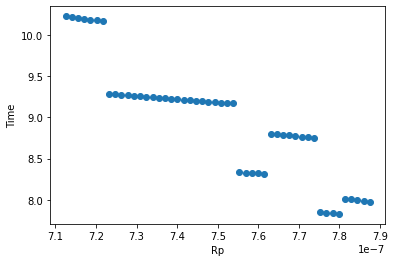

In [49]:
plt.plot(h['Rp_'],h['time_'],"o")
plt.xlabel('Rp')
plt.ylabel('Time')
plt.show()

<h3 style="color:blue">Histogram</h3>

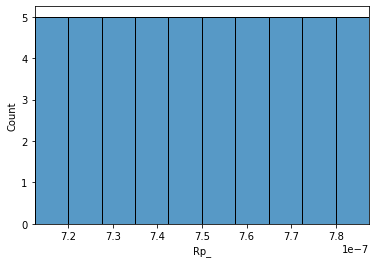

In [43]:
fig, ax = plt.subplots()
sns.histplot(h['Rp_'], bins = 10, ax = ax)
ax.set_xlim(7.5*10**(-7)-3.75*10**(-8), 7.5*10**(-7)+3.75*10**(-8))
plt.show()

<h3 style="color:green">Individual Trajectories</h3>

7.778313419811845
7.77828304830979


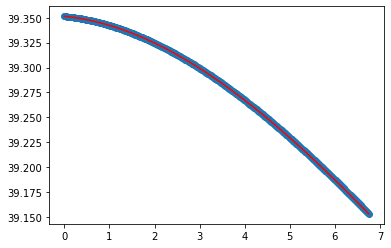

In [57]:
time = np.linspace(0,30,2000)
gamma_1 =  0.080879
gamma_2 = 0.080537
u0 = [39.351469,-0.004582 , 1.654382, 0, 4.081736, 0] 
sol1 = odeint(f, u0, time, args = (par, gamma_1, 7.216837e-07))
sol2 = odeint(f, u0, time, args = (par, gamma_2, 7.232143e-07))

plt.plot(time, sol1[:,0], "o") #blue is 0.0808
plt.plot(time, sol2[:,0], color = "red")
plt.show()
